In [1]:
import numpy as np
from facerec.plot import *

import tensorflow as tf
tf.config.list_physical_devices('GPU')

emotions = ["Marah", "Jijik", "Takut", "Senang", "Sedih", "Terkejut", "Biasa Saja"]

In [2]:
dt = np.load('../dataset/Fer2013_Training.npz')
images_train, labels_train = dt['x'], dt['y']
print(len(images_train))

10745


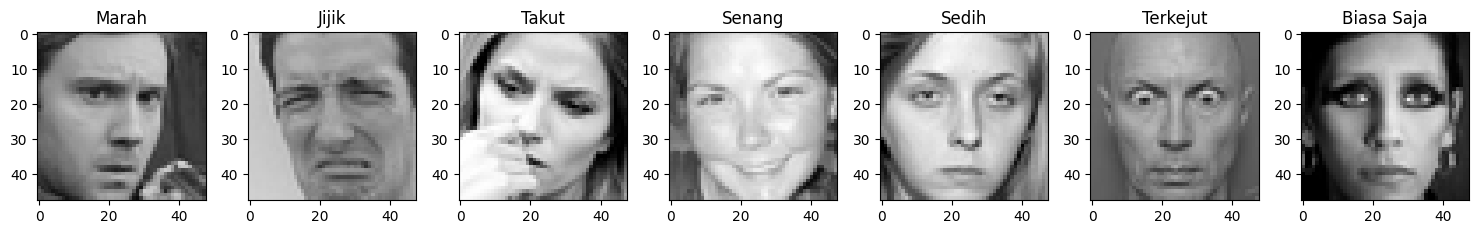

In [3]:
plot_figure(images_train, labels_train)

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(np.array(images_train).reshape(len(images_train),-1), labels_train)

In [5]:
def my_model():
	model = Sequential()
	input_shape = (48,48,1)

	model.add(Conv2D(64, (5,5), input_shape=input_shape, activation='relu'))
	model.add(Conv2D(64, (5,5), activation='relu', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D(pool_size=(2,2)))

	model.add(Conv2D(128, (5,5), activation='relu', padding='same'))
	model.add(Conv2D(128, (5,5), activation='relu', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D(pool_size=(2,2)))

	model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
	model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D(pool_size=(2,2)))

	model.add(Flatten())
	model.add(Dense(128))
	model.add(BatchNormalization())
	model.add(Activation('sigmoid'))
	model.add(Dropout(0.4))
	model.add(Dense(7))
	model.add(Activation('softmax'))

	sgd = SGD(learning_rate=0.5)
	model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=sgd)

	print(model.summary())
	return model

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.000005,
    patience=25,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=20,
    min_lr=0.25,
    verbose=1,
)

checkpoint = ModelCheckpoint(f"model/model_checkpoint.h5", monitor="val_accuracy", mode='auto', verbose=1, save_best_only=True)

callbacks = [
    early_stopping,
    lr_scheduler, checkpoint
]

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow(
									x=np.array(x_train).reshape(len(y_train), 48,48,1),
									y=to_categorical(y_train),
									batch_size=200)
test_set = test_datagen.flow(
									x=np.array(x_test).reshape(len(y_test), 48,48,1),
									y=to_categorical(y_test),
                                        batch_size=200)

In [8]:
model = my_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        102464    
                                                                 
 batch_normalization (BatchN  (None, 44, 44, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 128)       204928    
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 22, 128)       4

In [9]:
history = model.fit(training_set,validation_data=test_set,epochs=1000, verbose=1, callbacks=callbacks)

Epoch 1/1000
41/41 [==============================] - ETA: 0s - loss: 2.2022 - accuracy: 0.2049
Epoch 1: val_accuracy improved from -inf to 0.14365, saving model to model\model_checkpoint.h5
41/41 [==============================] - 34s 318ms/step - loss: 2.2022 - accuracy: 0.2049 - val_loss: 3.9063 - val_accuracy: 0.1437 - lr: 0.5000
Epoch 2/1000
41/41 [==============================] - ETA: 0s - loss: 1.9770 - accuracy: 0.2730
Epoch 2: val_accuracy improved from 0.14365 to 0.26535, saving model to model\model_checkpoint.h5
41/41 [==============================] - 10s 246ms/step - loss: 1.9770 - accuracy: 0.2730 - val_loss: 1.8289 - val_accuracy: 0.2654 - lr: 0.5000
Epoch 3/1000
41/41 [==============================] - ETA: 0s - loss: 1.8033 - accuracy: 0.3196
Epoch 3: val_accuracy did not improve from 0.26535
41/41 [==============================] - 10s 242ms/step - loss: 1.8033 - accuracy: 0.3196 - val_loss: 1.8168 - val_accuracy: 0.2248 - lr: 0.5000
Epoch 4/1000
41/41 [=============

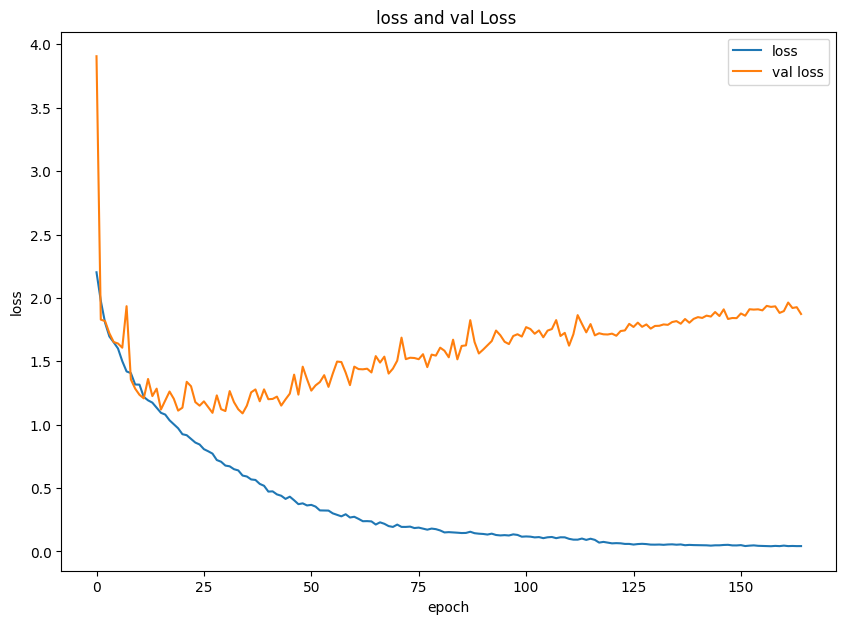

In [10]:
figure, axis = plt.subplots(figsize=(10,7))
axis.plot(history.history['loss'])
axis.plot(history.history['val_loss'])
axis.set_title('loss and val Loss ')
axis.legend(['loss','val loss'], loc='upper right')
axis.set(xlabel = 'epoch',ylabel='loss')
plt.show()

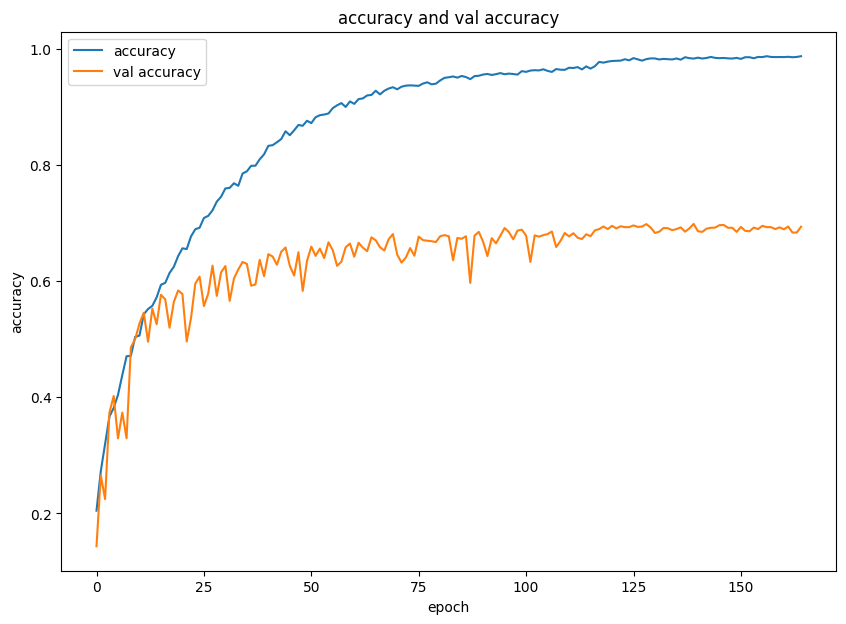

In [11]:

figure, axis = plt.subplots(figsize=(10,7))
axis.plot(history.history['accuracy'])
axis.plot(history.history['val_accuracy'])
axis.set_title('accuracy and val accuracy')
axis.legend(['accuracy','val accuracy'], loc='upper left')
axis.set(xlabel = 'epoch',ylabel='accuracy')
plt.show()

In [12]:
dt_t = np.load('../dataset/Fer2013_PrivateTest.npz')
images_test, labels_test = dt_t['x'], dt_t['y']

In [13]:
loss, acc = model.evaluate(np.array(images_test)/255.0, to_categorical(labels_test))
print(acc)

43/43 [==============================] - 1s 19ms/step - loss: 2.1040 - accuracy: 0.6496
0.6495916843414307
